In [1]:
# Connect to OpenEO
import openeo
from openeo.rest.job import JobResults
from openeo.rest.mlmodel import MlModel
import scipy
import numpy as np
from openeo.extra.spectral_indices import compute_indices
from openeo.processes import if_, is_nodata, array_concat, array_create
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score

connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


1. Prepared training and testing dataset from https://rapidmapping.emergency.copernicus.eu/EMSR685/
2. Prepared inference dataset from https://rapidmapping.emergency.copernicus.eu/EMSR671/
3. For the training, aoi created fetch Sentinel 2
4. On the Sentinel 2 calculated NBR, BAI, NDFI, GCLM contrast and variance as features for the model
5. Along with the above features, combined Sentinel 1 and Sentinel 2 bands
6. Aggregated the features spatially as RF takes single points
7. Trained the RF model
8. Now, with the model obtained, it can be used in the following three ways:
   1. Test the earlier split data
   2. Directly use the model to infer at a different location
   3. Save the model and the workflow as UDP and re-use it


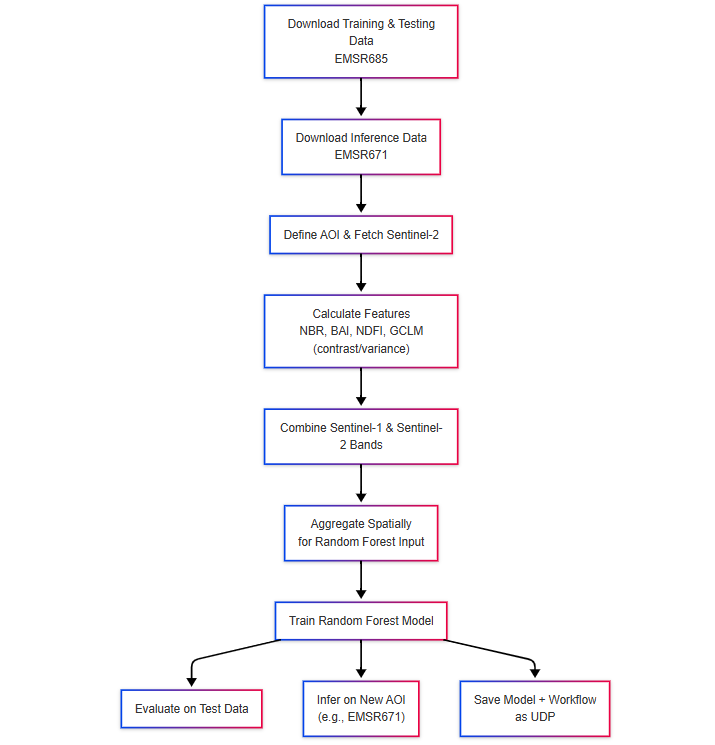

# Prep Functions

In [2]:
import json
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field

In [3]:
def get_cloud_free_pixels(scl, data, reducer="median"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

In [ ]:
# preprocessing in openEO
def prep_s2(date,file,reducer):
    aoi = read_json(file)
    # load S2 pre-collection
    s2_cube = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=date,
        spatial_extent=aoi,
        bands=["B02", "B03", "B04", "B08","B12"],
        max_cloud_cover=80,
    )
    
    s2_scl = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=date,
        spatial_extent=aoi,
        bands=["SCL"],
        max_cloud_cover=80,
    )
    
    # Create a Pre-event cloud-free mosaic
    cf_cube = get_cloud_free_pixels(s2_scl, s2_cube, reducer=reducer)

    # calculate all indices
    # NDFI Contrast GLCM Variance

    indices_list = ["NBR", "BAI"]
    indices = compute_indices(cf_cube, indices_list)

    # calculate texture features
    features_udf = openeo.UDF.from_file("features.py")
    features = cf_cube.apply_neighborhood(
        process=features_udf,
        size=[
            {"dimension": "x", "value": 128, "unit": "px"},
            {"dimension": "y", "value": 128, "unit": "px"},
        ],
        overlap=[
            {"dimension": "x", "value": 0, "unit": "px"},
            {"dimension": "y", "value": 0, "unit": "px"},
        ],
    )
    features = features.rename_labels(dimension = "bands", target = ["contrast","variance","NDFI"])
    
    # combine the original bands with the computed indices
    combined = cf_cube.merge_cubes(indices)
    combined = combined.merge_cubes(features)
    return combined

In [5]:
# preprocessing in openEO
def prep_s1(date,file,reducer):
    aoi = read_json(file)
    # load S2 pre-collection
    s1_cube = connection.load_collection(
        "SENTINEL1_GRD",
        temporal_extent=date,
        spatial_extent=aoi,
        bands=["VH", "VV"]
    )
    
    # apply SAR backscatter processing to the collection
    s1_cube = s1_cube.sar_backscatter(coefficient="sigma0-ellipsoid")

    # apply band-wise processing to create a ratio and log-transformed bands
    s1_cube = s1_cube.apply_dimension(
        dimension="bands",
        process=lambda x: array_create(
            [
                30.0 * x[0] / x[1],  # Ratio of VH to VV
                30.0 + 10.0 * x[0].log(base=10),  # Log-transformed VH
                30.0 + 10.0 * x[1].log(base=10),  # Log-transformed VV
            ]
        ),
    )

    s1_cube = s1_cube.rename_labels("bands", ["ratio"] + s1_cube.metadata.band_names)

    # scale to int16
    s1_cube = s1_cube.linear_scale_range(0, 30, 0, 30000)

    return s1_cube.reduce_dimension(reducer=reducer, dimension="t")

# Train and Test

## Train and Test Division of Data

In [ ]:
# Load Training data point Shapefile (Created in GIS Software by random sampling)

dataset = gpd.read_file("Dataset/training_dataset.geojson")
y_train, y_test = train_test_split(dataset, test_size=0.25, random_state=420)


ERROR 1: libpoppler.so.140: cannot open shared object file: No such file or directory
ERROR 1: libpoppler.so.140: cannot open shared object file: No such file or directory


In [7]:
training_date = ["2023-08-15", "2023-10-15"]
training_aoi = "Dataset/training_aoi.geojson"
s1_feature_cube = prep_s1(training_date,training_aoi,"median")
s2_feature_cube = prep_s2(training_date,training_aoi,"median")
training_cube = s2_feature_cube.merge_cubes(s1_feature_cube)


In [9]:

# Train the model and DOWNLOAD THE IMAGE USED FOR TRAINING The MODEL
predictors = training_cube.aggregate_spatial(json.loads(y_train.to_json()), reducer="median")
model = predictors.fit_class_random_forest(
    target=json.loads(y_train.to_json()),
    num_trees=200,
    seed=2082
)
# Save the model as a batch job result asset
# so that we can load it in another job.
model = model.save_ml_model()

In [10]:
training_job = model.create_job(title="RF for WF finalised")
training_job.start_and_wait()

0:00:00 Job 'j-25052516461141e0bbcca95d9541b623': send 'start'
0:00:19 Job 'j-25052516461141e0bbcca95d9541b623': created (progress 0%)
0:00:25 Job 'j-25052516461141e0bbcca95d9541b623': queued (progress 0%)
0:00:32 Job 'j-25052516461141e0bbcca95d9541b623': queued (progress 0%)
0:00:41 Job 'j-25052516461141e0bbcca95d9541b623': queued (progress 0%)
0:00:51 Job 'j-25052516461141e0bbcca95d9541b623': queued (progress 0%)
0:01:04 Job 'j-25052516461141e0bbcca95d9541b623': queued (progress 0%)
0:01:20 Job 'j-25052516461141e0bbcca95d9541b623': running (progress 9.5%)
0:01:40 Job 'j-25052516461141e0bbcca95d9541b623': running (progress 12.1%)
0:02:04 Job 'j-25052516461141e0bbcca95d9541b623': running (progress 15.2%)
0:02:35 Job 'j-25052516461141e0bbcca95d9541b623': running (progress 18.7%)
0:03:13 Job 'j-25052516461141e0bbcca95d9541b623': running (progress 22.6%)
0:04:00 Job 'j-25052516461141e0bbcca95d9541b623': running (progress 27.1%)
0:04:59 Job 'j-25052516461141e0bbcca95d9541b623': running (pr

<BatchJob job_id='j-25052516461141e0bbcca95d9541b623'>

In [11]:
# training_job = connection.job("j-25052514341146bd9fc508dfed443165")

In [12]:
results = training_job.get_results()
links = results.get_metadata()['links']
ml_model_metadata_url = [link for link in links if 'ml_model_metadata.json' in link['href']][0]['href']
print(ml_model_metadata_url)

https://openeo.vito.be/openeo/1.2/jobs/j-25052516461141e0bbcca95d9541b623/results/items/ZWNjZTlmZWEwNGI4YzljNzZhYzc2YjQ1YjZiYTAwYzIwZjIxMWJkYTQ4NTZjMTRhYTQ0NzViOGU4ZWQ0MzNjZEBlZ2kuZXU=/da32856ccabf0e20b615da06941898b4/ml_model_metadata.json?expires=1748797341


In [13]:
model = MlModel.load_ml_model(connection=connection, id=ml_model_metadata_url)

# Test

In [14]:
test_output = (
    training_cube.predict_random_forest(model=model, dimension="bands")
    .aggregate_spatial(json.loads(y_test.to_json()), reducer="mean")
)  # "https://github.com/openEOPlatform/sample-notebooks/raw/main/resources/landcover/model_item.json"
test_job = test_output.execute_batch(
    out_format="CSV", title="testing RF finalised",outputfile='y_pred_finalised.csv'
)

0:00:00 Job 'j-2505251702234d6ab0fdf0a53dd1270d': send 'start'
0:00:16 Job 'j-2505251702234d6ab0fdf0a53dd1270d': created (progress 0%)
0:00:22 Job 'j-2505251702234d6ab0fdf0a53dd1270d': queued (progress 0%)
0:00:28 Job 'j-2505251702234d6ab0fdf0a53dd1270d': queued (progress 0%)
0:00:36 Job 'j-2505251702234d6ab0fdf0a53dd1270d': queued (progress 0%)
0:00:46 Job 'j-2505251702234d6ab0fdf0a53dd1270d': queued (progress 0%)
0:00:59 Job 'j-2505251702234d6ab0fdf0a53dd1270d': queued (progress 0%)
0:01:14 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (progress 9.0%)
0:01:33 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (progress 11.5%)
0:01:58 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (progress 14.6%)
0:02:28 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (progress 18.1%)
0:03:05 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (progress 22.1%)
0:03:52 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (progress 26.6%)
0:04:51 Job 'j-2505251702234d6ab0fdf0a53dd1270d': running (pr

In [15]:
import pandas as pd
y_test_res = pd.read_csv("y_pred_finalised.csv")
y_test_res.index = pd.to_numeric(y_test_res.feature_index, errors='coerce')
y_test_res = y_test_res.sort_index()

In [16]:
y_test['predicted'] = y_test_res.band_unnamed.to_numpy()

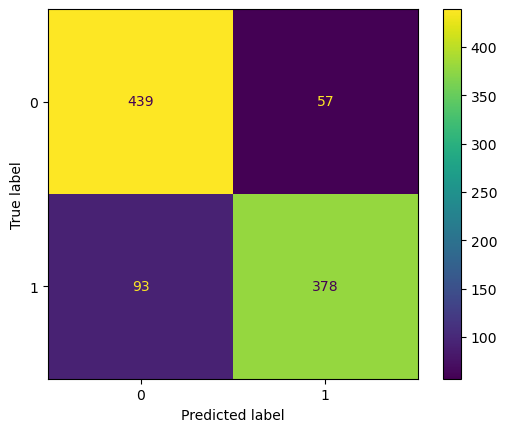

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test["target"], y_test["predicted"])

In [18]:
accuracy_score(y_test["target"], y_test["predicted"])

0.8448810754912099

# Inference

In [22]:
inference_date = ["2023-07-15", "2023-09-15"]
inference_aoi = "Dataset/inference_aoi.geojson"

s1_feature_cube_in = prep_s1(inference_date,inference_aoi,"median")
s2_feature_cube_in = prep_s2(inference_date,inference_aoi,"median")
inference_cube = s2_feature_cube_in.merge_cubes(s1_feature_cube_in)


In [23]:
# predict of training data
inference = inference_cube.predict_random_forest(
    model=model,
    dimension="bands"
)

In [25]:
inference.execute_batch(outputfile="inference_finalised_vito.nc", title="Inference finalised")